# _import modules & set constants:_

In [2]:
# enable in-line MatPlotLib
%matplotlib inline

In [85]:
# import Python modules
from __future__ import division, print_function
from matplotlib import pyplot
import numpy
import os
import pandas
import sys

In [4]:
# set CONSTANTS

# using AWS EMR?
AWS_EMR_MODE = os.path.expanduser('~') == '/home/hadoop'

# data paths
DATA_FILE_NAME = 'Accidents.csv'
DATA_FOLDER_NAME = 'TransportAccidentsData'
DATA_REPO_URL = 'https://github.com/ChicagoBoothML/DATA___TransportAccidents'
    
# number of examples to display for a data set
NB_EXAMPLES_TO_SHOW = 9

# random_seed
RANDOM_SEED = 99

# Apache Spark settings
if AWS_EMR_MODE:
    SPARK_MODE = 'yarn-client'                 # running Spark on AWS EMR YARN cluster
    SPARK_HOME = '/usr/lib/spark'              # default Spark installation folder on AWS EMR master node
    SPARK_DRIVER_MEMORY = '9g'                 # memory allocated to MapReduce driver process
    SPARK_EXECUTOR_MEMORY = '3g'               # memory allocated to each MapReduce executor process
    SPARK_DRIVER_MAX_RESULT_SIZE = '6g'        # maximum size of objects collected back to MapReduce driver process
else:
    SPARK_MODE = 'local'                       # running Spark on single machine
    SPARK_HOME = '/Applications/spark-1.5.2'   # Spark installation folder on my machine
    SPARK_DRIVER_MEMORY = '5g'                 # memory allocated to MapReduce driver process 
    SPARK_EXECUTOR_MEMORY = '1g'               # memory allocated to each MapReduce executor process
    SPARK_DRIVER_MAX_RESULT_SIZE = '3g'        # maximum size of objects collected back to MapReduce driver process

In [5]:
# install ChicagoBoothML_Helpy
CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND = \
    'pip install --upgrade git+git://GitHub.com/ChicagoBoothML/Helpy --no-dependencies'
if AWS_EMR_MODE:
    os.system('sudo %s' % CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND)
else:
    os.system(CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND)

# import from package
from ChicagoBoothML_Helpy.EvaluationMetrics import bin_classif_eval
from ChicagoBoothML_Helpy.Print import printflush

# Launch PySpark and set up SparkContext & HiveContext

In [6]:
if 'pyspark' not in vars():   # set up Apache Spark environment if not yet done so
    
    # set environment variables for Spark
    os.environ['SPARK_HOME'] = SPARK_HOME
    os.environ['SPARK_HIVE'] = 'true'
    
    # enable importing of PySpark through FindSpark package
    import findspark
    findspark.init()
    
    # import PySpark and set up SparkContext ("sc") & HiveContext ("hc")
    import pyspark
    
    sc = pyspark.SparkContext(
        conf=pyspark.SparkConf()
            .setMaster(SPARK_MODE)
            .setAppName('BostonHousing')
            .set('spark.driver.memory', SPARK_DRIVER_MEMORY)
            .set('spark.executor.memory', SPARK_EXECUTOR_MEMORY)
            .set('spark.driver.maxResultSize', SPARK_DRIVER_MAX_RESULT_SIZE))
    
    hc = pyspark.sql.HiveContext(sc)
    
print('SparkContext:', sc)
print('HiveContext:', hc)

SparkContext: <pyspark.context.SparkContext object at 0x7fb846a89410>
HiveContext: <pyspark.sql.context.HiveContext object at 0x7fb846995fd0>


In [44]:
# imports from PySpark
from pyspark.ml import Pipeline
from pyspark.ml.feature import \
    OneHotEncoder, \
    StandardScaler, \
    StringIndexer, \
    VectorAssembler
from pyspark.ml.evaluation import \
    BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator
from pyspark.ml.classification import \
    RandomForestClassifier as SparkML_RandomForestClassifier, \
    GBTClassifier as SparkML_GBTClassifier, \
    LogisticRegression as SparkML_LogisticRegression
from pyspark.ml.tuning import \
    CrossValidator, \
    ParamGridBuilder

# Download PySpark_CSV.py and put it into SparkContext

In [8]:
# download PySpark_CSV.py and put it into SparkContext
!curl https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py --output pyspark_csv.py

sc.addPyFile('pyspark_csv.py')

from pyspark_csv import csvToDataFrame

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5493  100  5493    0     0  13923      0 --:--:-- --:--:-- --:--:-- 13941


# Download, parse & preprocess data

In [27]:
# download data
os.system('git clone %s %s' % (DATA_REPO_URL, DATA_FOLDER_NAME))

if AWS_EMR_MODE:   # put into Hadoop HDFS
    os.system('hadoop fs -put %s %s'
              % (os.path.join(DATA_FOLDER_NAME, DATA_FILE_NAME), DATA_FILE_NAME))
elif sys.platform.startswith('win'):   # move file out
    os.system('copy /y %s %s'
              % (os.path.join(DATA_FOLDER_NAME, DATA_FILE_NAME), DATA_FILE_NAME))
else:
    os.system('yes | cp -rf %s %s'
              % (os.path.join(DATA_FOLDER_NAME, DATA_FILE_NAME), DATA_FILE_NAME))

In [28]:
# read data into distributed data frame
accidents_ddf = \
    csvToDataFrame(
        sqlCtx=hc,
        rdd=sc.textFile(DATA_FILE_NAME),
        columns=None,
        sep=',',
        parseDate=True)\
    .cache()

accidents_ddf.registerTempTable('accidents')

accidents_ddf.show(NB_EXAMPLES_TO_SHOW)

+--------+-------+-------+---------+--------+--------+-------+----------+----------+---------+----------+---------+----------+-------+--------+----------+--------+--------+---------+------------+--------+--------------+----------+----------+
|HOUR_I_R|ALCHL_I|ALIGN_I|STRATUM_R|WRK_ZONE|WKDY_I_R|INT_HWY|LGTCON_I_R|MANCOL_I_R|PED_ACC_R|RELJCT_I_R|REL_RWY_R|PROFIL_I_R|SPD_LIM|SUR_COND|TRAF_CON_R|TRAF_WAY|VEH_INVL|WEATHER_R|INJURY_CRASH|NO_INJ_I|PRPTYDMG_CRASH|FATALITIES|MAX_SEV_IR|
+--------+-------+-------+---------+--------+--------+-------+----------+----------+---------+----------+---------+----------+-------+--------+----------+--------+--------+---------+------------+--------+--------------+----------+----------+
|       0|      2|      2|        1|       0|       1|      0|         3|         0|        0|         1|        0|         1|     40|       4|         0|       3|       1|        1|           1|       1|             0|         0|         1|
|       1|      2|      1|      

In [32]:
accidents_ddf.printSchema()

root
 |-- HOUR_I_R: integer (nullable = true)
 |-- ALCHL_I: integer (nullable = true)
 |-- ALIGN_I: integer (nullable = true)
 |-- STRATUM_R: integer (nullable = true)
 |-- WRK_ZONE: integer (nullable = true)
 |-- WKDY_I_R: integer (nullable = true)
 |-- INT_HWY: integer (nullable = true)
 |-- LGTCON_I_R: integer (nullable = true)
 |-- MANCOL_I_R: integer (nullable = true)
 |-- PED_ACC_R: integer (nullable = true)
 |-- RELJCT_I_R: integer (nullable = true)
 |-- REL_RWY_R: integer (nullable = true)
 |-- PROFIL_I_R: integer (nullable = true)
 |-- SPD_LIM: integer (nullable = true)
 |-- SUR_COND: integer (nullable = true)
 |-- TRAF_CON_R: integer (nullable = true)
 |-- TRAF_WAY: integer (nullable = true)
 |-- VEH_INVL: integer (nullable = true)
 |-- WEATHER_R: integer (nullable = true)
 |-- INJURY_CRASH: integer (nullable = true)
 |-- NO_INJ_I: integer (nullable = true)
 |-- PRPTYDMG_CRASH: integer (nullable = true)
 |-- FATALITIES: integer (nullable = true)
 |-- MAX_SEV_IR: integer (null

In [40]:
y_var_name = 'MAX_SEV_IR'

categorical_X_var_names = \
    ['HOUR_I_R',
     'ALIGN_I',
     'STRATUM_R',
     'WRK_ZONE',
     'WKDY_I_R',
     'INT_HWY',
     'LGTCON_I_R',
     'MANCOL_I_R',
     'PED_ACC_R',
     'RELJCT_I_R',
     'REL_RWY_R',
     'PROFIL_I_R',
     'SUR_COND',
     'TRAF_CON_R',
     'TRAF_WAY',
     'WEATHER_R']

numerical_X_var_names = \
    ['SPD_LIM',
     'VEH_INVL']

In [38]:
# label data clearly
accidents_ddf = hc.sql(
    "SELECT \
        CASE \
            WHEN `HOUR_I_R` = 0 THEN 'non_rush_hour' \
            WHEN `HOUR_I_R` = 1 THEN 'rush_hour' \
            END \
            AS `HOUR_I_R`, \
        CASE \
            WHEN `ALCHL_I` = 1 THEN 'alcohol' \
            WHEN `ALCHL_I` = 2 THEN 'no_alcohol' \
            END \
            AS `ALCHL_I`, \
        CASE \
            WHEN `ALIGN_I` = 1 THEN 'straight_road' \
            WHEN `ALIGN_I` = 2 THEN 'curved_road' \
            END \
            AS `ALIGN_I`, \
        CASE \
            WHEN `STRATUM_R` = 0 THEN 'no_other_vehicles_towed' \
            WHEN `STRATUM_R` = 1 THEN 'other_vehicles_towed' \
            END \
            AS `STRATUM_R`, \
        CASE \
            WHEN `WRK_ZONE` = 0 THEN 'not_work_zone' \
            WHEN `WRK_ZONE` = 1 THEN 'work_zone' \
            END \
            AS `WRK_ZONE`, \
        CASE \
            WHEN `WKDY_I_R` = 0 THEN 'weekend' \
            WHEN `WKDY_I_R` = 1 THEN 'weekday' \
            END \
            AS `WKDY_I_R`, \
        CASE \
            WHEN `INT_HWY` = 0 THEN 'not_interstate' \
            WHEN `INT_HWY` = 1 THEN 'interstate' \
            WHEN `INT_HWY` = 9 THEN 'unknown' \
            END \
            AS `INT_HWY`, \
        CASE \
            WHEN `LGTCON_I_R` = 1 THEN 'day' \
            WHEN `LGTCON_I_R` = 2 THEN 'dark' \
            WHEN `LGTCON_I_R` = 3 THEN 'dark_but_lighted' \
            END \
            AS `LGTCON_I_R`, \
        CASE \
            WHEN `MANCOL_I_R` = 0 THEN 'no_collison' \
            WHEN `MANCOL_I_R` = 1 THEN 'head_on_collison' \
            WHEN `MANCOL_I_R` = 2 THEN 'other_collison' \
            END \
            AS `MANCOL_I_R`, \
        CASE \
            WHEN `PED_ACC_R` = 0 THEN 'no_pedestrian_or_cyclist_involved' \
            WHEN `PED_ACC_R` = 1 THEN 'pedestrian_or_cyclist_involved' \
            END \
            AS `PED_ACC_R`, \
        CASE \
            WHEN `RELJCT_I_R` = 0 THEN 'not_at_intersection' \
            WHEN `RELJCT_I_R` = 1 THEN 'at_intersection' \
            END \
            AS `RELJCT_I_R`, \
        CASE \
            WHEN `REL_RWY_R` = 0 THEN 'not_on_roadway' \
            WHEN `REL_RWY_R` = 1 THEN 'on_roadway' \
            END \
            AS `REL_RWY_R`, \
        CASE \
            WHEN `PROFIL_I_R` = 0 THEN 'other' \
            WHEN `PROFIL_I_R` = 1 THEN 'level' \
            END \
            AS `PROFIL_I_R`, \
        CAST(`SPD_LIM` AS DOUBLE) AS `SPD_LIM`, \
        CASE \
            WHEN `SUR_COND` = 1 THEN 'dry' \
            WHEN `SUR_COND` = 2 THEN 'wet' \
            WHEN `SUR_COND` = 3 THEN 'snow_or_slush' \
            WHEN `SUR_COND` = 4 THEN 'ice' \
            WHEN `SUR_COND` = 9 THEN 'unknown' \
            END \
            AS `SUR_COND`, \
        CASE \
            WHEN `TRAF_CON_R` = 0 THEN 'no_traffic_control' \
            WHEN `TRAF_CON_R` = 1 THEN 'signal_traffic_control' \
            WHEN `TRAF_CON_R` = 2 THEN 'other_traffic_control' \
            END \
            AS `TRAF_CON_R`, \
        CASE \
            WHEN `TRAF_WAY` = 1 THEN 'two_way_traffic' \
            WHEN `TRAF_WAY` = 2 THEN 'divided_highway' \
            WHEN `TRAF_WAY` = 3 THEN 'one_way_road' \
            END \
            AS `TRAF_WAY`, \
        CAST(`VEH_INVL` AS DOUBLE) AS `VEH_INVL`, \
        CASE \
            WHEN `WEATHER_R` = 1 THEN 'no_adverse_weather' \
            WHEN `WEATHER_R` = 2 THEN 'adverse_weather' \
            END \
            AS `WEATHER_R`, \
        CASE \
            WHEN `INJURY_CRASH` = 0 THEN 'no_injury' \
            WHEN `INJURY_CRASH` = 1 THEN 'injury' \
            END \
            AS `INJURY_CRASH`, \
        CAST(`NO_INJ_I` AS DOUBLE) AS `NO_INJ_I`, \
        CASE \
            WHEN `PRPTYDMG_CRASH` = 0 THEN 'no_property_damage' \
            WHEN `PRPTYDMG_CRASH` = 1 THEN 'property_damage' \
            END \
            AS `PRPTYDMG_CRASH`, \
        CASE \
            WHEN `FATALITIES` = 0 THEN 'no_fatalities' \
            WHEN `FATALITIES` = 1 THEN 'fatalities' \
            END \
            AS `FATALITIES`, \
        CASE \
            WHEN `MAX_SEV_IR` = 0 THEN 'no_injury' \
            WHEN `MAX_SEV_IR` = 1 THEN 'non_fatal_injury' \
            WHEN `MAX_SEV_IR` = 2 THEN 'fatal_injury' \
            END \
            AS `MAX_SEV_IR` \
    FROM \
        accidents")\
    .cache()

accidents_ddf.registerTempTable('accidents')

accidents_ddf.printSchema()

root
 |-- HOUR_I_R: string (nullable = true)
 |-- ALCHL_I: string (nullable = true)
 |-- ALIGN_I: string (nullable = true)
 |-- STRATUM_R: string (nullable = true)
 |-- WRK_ZONE: string (nullable = true)
 |-- WKDY_I_R: string (nullable = true)
 |-- INT_HWY: string (nullable = true)
 |-- LGTCON_I_R: string (nullable = true)
 |-- MANCOL_I_R: string (nullable = true)
 |-- PED_ACC_R: string (nullable = true)
 |-- RELJCT_I_R: string (nullable = true)
 |-- REL_RWY_R: string (nullable = true)
 |-- PROFIL_I_R: string (nullable = true)
 |-- SPD_LIM: double (nullable = true)
 |-- SUR_COND: string (nullable = true)
 |-- TRAF_CON_R: string (nullable = true)
 |-- TRAF_WAY: string (nullable = true)
 |-- VEH_INVL: double (nullable = true)
 |-- WEATHER_R: string (nullable = true)
 |-- INJURY_CRASH: string (nullable = true)
 |-- NO_INJ_I: double (nullable = true)
 |-- PRPTYDMG_CRASH: string (nullable = true)
 |-- FATALITIES: string (nullable = true)
 |-- MAX_SEV_IR: string (nullable = true)



In [41]:
# count data completeness --> no missing data problem
data_completeness_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        accidents"
    % ', '.join(['COUNT(`%s`) AS `%s`' % (v, v)
                 for v in [y_var_name] + categorical_X_var_names + numerical_X_var_names]))

data_completeness_ddf.show()

+----------+--------+-------+---------+--------+--------+-------+----------+----------+---------+----------+---------+----------+--------+----------+--------+---------+-------+--------+
|MAX_SEV_IR|HOUR_I_R|ALIGN_I|STRATUM_R|WRK_ZONE|WKDY_I_R|INT_HWY|LGTCON_I_R|MANCOL_I_R|PED_ACC_R|RELJCT_I_R|REL_RWY_R|PROFIL_I_R|SUR_COND|TRAF_CON_R|TRAF_WAY|WEATHER_R|SPD_LIM|VEH_INVL|
+----------+--------+-------+---------+--------+--------+-------+----------+----------+---------+----------+---------+----------+--------+----------+--------+---------+-------+--------+
|     42183|   42183|  42183|    42183|   42183|   42183|  42183|     42183|     42183|    42183|     42183|    42183|     42183|   42183|     42183|   42183|    42183|  42183|   42183|
+----------+--------+-------+---------+--------+--------+-------+----------+----------+---------+----------+---------+----------+--------+----------+--------+---------+-------+--------+



In [42]:
# split Train & Test sets:
accidents_train_ddf, accidents_test_ddf = \
    accidents_ddf.randomSplit(
        weights=[.75, .25],
        seed=RANDOM_SEED)

# Build model pipelines

In [45]:
string_categorical_indexed_feature_names = []
string_categorical_feature_string_indexers = {}

string_categorical_one_hot_encoded_feature_names = []
string_categorical_feature_one_hot_encoders = {}

for feature_name in categorical_X_var_names:
    
    string_indexed_feature_name = '%s___idx' % feature_name
    string_categorical_indexed_feature_names.append(
        string_indexed_feature_name)
    string_indexer = \
        StringIndexer(
            inputCol=feature_name,
            outputCol=string_indexed_feature_name)\
        .fit(dataset=accidents_train_ddf)
    string_categorical_feature_string_indexers[feature_name] = \
        string_indexer
    
    one_hot_encoded_feature_name = '%s___ohe' % feature_name
    string_categorical_one_hot_encoded_feature_names.append(
        one_hot_encoded_feature_name)
    one_hot_encoder = \
        OneHotEncoder(        
            inputCol=string_indexed_feature_name,
            outputCol=one_hot_encoded_feature_name)
    string_categorical_feature_one_hot_encoders[feature_name] = \
        one_hot_encoder
        
    print('Pre-Processing for %s:' % feature_name)
    one_hot_encoder.transform(
        string_indexer.transform(accidents_train_ddf))\
    .select(feature_name,
            string_indexed_feature_name,
            one_hot_encoded_feature_name)\
    .show(NB_EXAMPLES_TO_SHOW)

Pre-Processing for HOUR_I_R:
+-------------+--------------+--------------+
|     HOUR_I_R|HOUR_I_R___idx|HOUR_I_R___ohe|
+-------------+--------------+--------------+
|non_rush_hour|           0.0| (1,[0],[1.0])|
|    rush_hour|           1.0|     (1,[],[])|
|    rush_hour|           1.0|     (1,[],[])|
|    rush_hour|           1.0|     (1,[],[])|
|    rush_hour|           1.0|     (1,[],[])|
|    rush_hour|           1.0|     (1,[],[])|
|    rush_hour|           1.0|     (1,[],[])|
|    rush_hour|           1.0|     (1,[],[])|
|    rush_hour|           1.0|     (1,[],[])|
+-------------+--------------+--------------+
only showing top 9 rows

Pre-Processing for ALIGN_I:
+-------------+-------------+-------------+
|      ALIGN_I|ALIGN_I___idx|ALIGN_I___ohe|
+-------------+-------------+-------------+
|  curved_road|          1.0|    (1,[],[])|
|straight_road|          0.0|(1,[0],[1.0])|
|straight_road|          0.0|(1,[0],[1.0])|
|straight_road|          0.0|(1,[0],[1.0])|
|straight_ro

In [46]:
feature_vector_assembler = \
    VectorAssembler(
        inputCols=
            string_categorical_one_hot_encoded_feature_names +
            numerical_X_var_names,
        outputCol='accident_features')

In [48]:
label_string_indexer = \
    StringIndexer(
        inputCol=y_var_name,
        outputCol='%s___idx' % y_var_name)\
    .fit(accidents_train_ddf)

In [51]:
rf_classifier = \
    SparkML_RandomForestClassifier(
        featuresCol='accident_features',
        labelCol='%s___idx' % y_var_name,
        predictionCol='y_hat',
        probabilityCol='p_hat',
        rawPredictionCol='raw_pred',
        maxDepth=9,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        seed=RANDOM_SEED,
        impurity='entropy',
        numTrees=900,
        featureSubsetStrategy='auto')
    
rf_pipeline_estimator = \
    Pipeline(
        stages=
            string_categorical_feature_string_indexers.values() +
            string_categorical_feature_one_hot_encoders.values() +
            [feature_vector_assembler,
             label_string_indexer,
             rf_classifier])

In [53]:
gbt_classifier = \
    SparkML_GBTClassifier(
        featuresCol='accident_features',
        labelCol='%s___idx' % y_var_name,
        predictionCol='y_hat',
        maxDepth=3,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.0,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        lossType='logistic',
        maxIter=10,   # small number of trees to avoid Stack Overflow
        stepSize=.1)

gbt_pipeline_estimator = \
    Pipeline(
        stages=
            string_categorical_feature_string_indexers.values() +
            string_categorical_feature_one_hot_encoders.values() +
            [feature_vector_assembler,
             label_string_indexer,
             gbt_classifier])

# Fit models

In [52]:
rf_model = \
    rf_pipeline_estimator.fit(
        dataset=accidents_train_ddf)

In [55]:
# SKIPPING GBT CLASSIFIER: only supports Binary Classification currently
# gbt_model = \
#    gbt_pipeline_estimator.fit(
#        dataset=accidents_train_ddf)

# Make Predictions

In [57]:
rf_predictions_ddf = \
    rf_model.transform(
        dataset=accidents_test_ddf)\
    .select(
        y_var_name,
        '%s___idx' % y_var_name,
        'p_hat',
        'y_hat')\
    .cache()

rf_predictions_ddf.registerTempTable('rf_predictions')
    
rf_predictions_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------+----------------+--------------------+-----+
|MAX_SEV_IR|MAX_SEV_IR___idx|               p_hat|y_hat|
+----------+----------------+--------------------+-----+
| no_injury|             1.0|[0.28095583681560...|  1.0|
| no_injury|             1.0|[0.20581259971997...|  1.0|
| no_injury|             1.0|[0.34547065298929...|  1.0|
| no_injury|             1.0|[0.35242717598473...|  1.0|
| no_injury|             1.0|[0.34315818535879...|  1.0|
| no_injury|             1.0|[0.39312528085806...|  1.0|
| no_injury|             1.0|[0.31706283402895...|  1.0|
| no_injury|             1.0|[0.40787655299104...|  1.0|
| no_injury|             1.0|[0.37101890298236...|  1.0|
+----------+----------------+--------------------+-----+
only showing top 9 rows



# Evaluate Predictions

In [78]:
y_index_df = hc.sql(
    "SELECT \
        `MAX_SEV_IR___idx`, \
        FIRST_VALUE(`MAX_SEV_IR`) AS `MAX_SEV_IR` \
    FROM \
        rf_predictions \
    GROUP BY \
        `MAX_SEV_IR___idx` \
    ORDER BY \
        `MAX_SEV_IR___idx`")\
    .toPandas()

y_index_df = \
    y_index_df.reindex(
        index=y_index_df.MAX_SEV_IR___idx, 
        columns=['MAX_SEV_IR'])

y_index_df

,MAX_SEV_IR
MAX_SEV_IR___idx,
0,non_fatal_injury
1,no_injury
2,fatal_injury


In [80]:
y = numpy.array(
    rf_predictions_ddf\
        .select('MAX_SEV_IR___idx')\
        .rdd\
        .map(lambda row: row[0])\
        .collect())

y

array([ 1.,  1.,  1., ...,  0.,  1.,  0.])

In [90]:
p_hat_df = pandas.DataFrame(
    data=numpy.array(
        rf_predictions_ddf\
        .select('p_hat')\
        .rdd\
        .map(lambda row: row[0])\
        .collect()),
    columns=y_index_df.MAX_SEV_IR)
    
p_hat_df

MAX_SEV_IR,non_fatal_injury,no_injury,fatal_injury
0,0.280956,0.717836,0.001208
1,0.205813,0.791397,0.002790
2,0.345471,0.649634,0.004896
3,0.352427,0.643403,0.004170
4,0.343158,0.654131,0.002710
5,0.393125,0.588234,0.018641
6,0.317063,0.675814,0.007123
7,0.407877,0.576349,0.015775
8,0.371019,0.626993,0.001989
9,0.297028,0.701139,0.001833


In [91]:
# generate decision thresholds
low_prob = 1e-6
high_prob = 1 - low_prob
log_low_prob = numpy.log(low_prob)
log_high_prob = numpy.log(high_prob)
log_prob_thresholds = numpy.linspace(start=log_low_prob, stop=log_high_prob, num=100)
prob_thresholds = numpy.exp(log_prob_thresholds)

In [105]:
rf_oos_performance_for_no_injury = \
    bin_classif_eval(
        p_hat_df.loc[:, 'no_injury'],
        y==y_index_df.loc[(y_index_df.MAX_SEV_IR == 'no_injury')].index[0],
        pos_cat=1, thresholds=prob_thresholds)

In [106]:
rf_oos_performance_for_non_fatal_injury = \
    bin_classif_eval(
        p_hat_df.loc[:, 'non_fatal_injury'],
        y==y_index_df.loc[(y_index_df.MAX_SEV_IR == 'non_fatal_injury')].index[0],
        pos_cat=1, thresholds=prob_thresholds)

In [107]:
rf_oos_performance_for_fatal_injury = \
    bin_classif_eval(
        p_hat_df.loc[:, 'fatal_injury'],
        y==y_index_df.loc[(y_index_df.MAX_SEV_IR == 'fatal_injury')].index[0],
        pos_cat=1, thresholds=prob_thresholds)

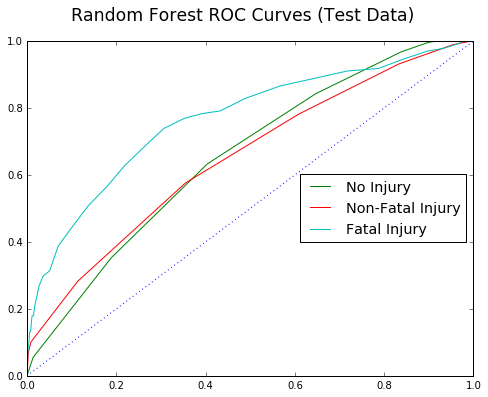

In [108]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),
    'figure.titlesize': 'xx-large',
    'legend.fontsize': 'x-large'})

fig, ax = pyplot.subplots()

ax.plot(
    [0, 1], [0, 1],
    linestyle='dotted')

ax.plot(
    1 - rf_oos_performance_for_no_injury.specificity,
    rf_oos_performance_for_no_injury.recall,
    label='No Injury')

ax.plot(
    1 - rf_oos_performance_for_non_fatal_injury.specificity,
    rf_oos_performance_for_non_fatal_injury.recall,
    label='Non-Fatal Injury')

ax.plot(
    1 - rf_oos_performance_for_fatal_injury.specificity,
    rf_oos_performance_for_fatal_injury.recall,
    label='Fatal Injury')

ax.legend(loc='right')
fig.suptitle('Random Forest ROC Curves (Test Data)')